# PyTrilinos2 tutorial

In this tutorial we will discuss how `PyTrilinos2` generates a Python interface to Trilinos and how to use the interface to solve a linear system of equations.

This tutorial is available at [https://github.com/trilinos/pytrilinos2_container](https://github.com/trilinos/pytrilinos2_container).

## Generation of Python interfaces

The vast majority of Trilinos is written in C++. 
Functionality can be exposed to Python using pybind11 [https://github.com/pybind/pybind11](https://github.com/pybind/pybind11).

An example from the pybind11 documentation:

The C++ function
```C++
int add(int i, int j) {
    return i + j;
}
```
can be exposed to Python like so:

```C++
#include <pybind11/pybind11.h>

int add(int i, int j) {
    return i + j;
}

PYBIND11_MODULE(example, m) {
    m.doc() = "pybind11 example plugin"; // optional module docstring

    m.def("add", &add, "A function that adds two numbers");
}
```
After compilation into a shared library, the module can be imported from Python.

There is a lot of code in Trilinos, and we do not want to write (and maintain) wrappers by hand.
Instead, we use binder [https://github.com/RosettaCommons/binder](https://github.com/RosettaCommons/binder).
Using LLVM tools, it parses source code and generates the pybind11 source files.
We give binder some header files and it greedily searches through all includes.
Via a configuration file we include or exclude namespaces, classes and functions and add custom code.

For example, we use this file as a starting point for the search of Tpetra includes

In [1]:
%%bash
cat $TRILINOS_BUILD_DIR/packages/PyTrilinos2/src/PyTrilinos2_Tpetra_ETI.hpp

#ifndef PYTRILINOS2_TPETRA_ETI
#define PYTRILINOS2_TPETRA_ETI

#include <Tpetra_CrsMatrix_DOUBLE_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_CrsMatrix_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_CrsMatrix_INT_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_CrsMatrix_LONG_LONG_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FECrsMatrix_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FECrsMatrix_INT_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FECrsMatrix_LONG_LONG_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FEMultiVector_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FEMultiVector_INT_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_FEMultiVector_LONG_LONG_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_MultiVector_DOUBLE_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_MultiVector_DOUBLE_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_MultiVector_INT_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_MultiVector_LONG_LONG_INT_LONG_LONG_SERIAL.cpp>
#include <Tpetra_Vector_DOUBLE_INT_LONG_LONG_SERIAL.cpp>


and these configuration options:

In [2]:
%%bash
configFile=$TRILINOS_DIR/packages/PyTrilinos2/scripts/PyTrilinos2_config.cfg
lineNo=`grep -n "# Tpetra" $configFile | cut -d : -f 1`
tail -n +"$lineNo" $TRILINOS_DIR/packages/PyTrilinos2/scripts/PyTrilinos2_config.cfg | head -n 15

# Tpetra
+namespace Tpetra
+add_on_binder_for_namespace Tpetra def_initialize_Kokkos
+include_for_namespace Tpetra <PyTrilinos2_Tpetra_Custom.hpp>
+include <PyTrilinos2_Tpetra_Types.hpp>
+add_on_binder Tpetra::CrsGraph define_CrsGraph_member_functions
+add_on_binder Tpetra::Vector define_Vector_member_functions
+add_on_binder Tpetra::MultiVector define_MultiVector_member_functions
+add_on_binder Tpetra::CrsMatrix define_CrsMatrix_member_functions
-namespace Tpetra::Details
-namespace Tpetra::Import_Util
-namespace Tpetra::KokkosRefactor
-class Tpetra::BlockCrsMatrix
-class Tpetra::Details::DistributorPlan
-class Tpetra::Directory


## A Python interface for Trilinos

We will now use the Python interface of Trilinos (`PyTrilinos2`) to set up and solve a linear system (using `Tpetra` and `Thyra`) using different linear solvers and preconditioners from `Amesos2`, `Belos`, `Ifpack2` and `MueLu`.

In [3]:
# get std::cout to show up in Jupyter notbooks
%load_ext redirect

### Setting up the linear system

The Tpetra package provides sparse linear algebra.

In [4]:
from PyTrilinos2 import Tpetra

Tpetra linear algebra classes are templated on

- scalar type, e.g. `double`, `float`, `std::complex<double>`
- local ordinal type, normally `int`
- global ordinal type, normally `long long`
- node type, a combination of a Kokkos execution space and memory space.
  
Python does not have templates, so templated C++ classes are exposed as Python classes with template parameters attached to the class name.
For example `Tpetra::Map<int, long long, Tpetra::KokkkosCompat::KokkosDeviceWrapperNode<Kokkos::Serial> >` becomes

In [5]:
Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

Since that's not very convenient (and different from C++) `PyTrilinos2` has some helper classes that map template parameters to classes:

In [6]:
Tpetra.Map['int', 'long long', 'serial']

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

We can leverage default values for template arguments to further simplify:

In [7]:
Tpetra.Map['int']

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

In [8]:
Tpetra.Map[()]  # no arguments specified, note ()

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

We set up a linear system
$$A x = b,$$
where $A$ is a 1D Laplacian and $b$ is a vector of all ones.

We first need to set up a `Tpetra::Map` that describes the parallel distribution of data. We are running on a single rank, so that's quite simple.
We can display information about the available constructors and methods using

In [9]:
help(Tpetra.MultiVector[()])

Help on class MultiVector_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t in module PyTrilinos2.PyTrilinos2.Tpetra:

class MultiVector_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t(DistObject_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t)
 |  Method resolution order:
 |      MultiVector_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t
 |      DistObject_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t
 |      SrcDistObject
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |
 |      1. __init__(self: PyTrilinos2.PyTrilinos2.Tpetra.MultiVector_double_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t) -> None
 |
 |      2. __init__(self: PyTrilinos2.PyTrilinos2.Tpetra.Multi

We set up a MPI communicator and an output stream:

In [10]:
from mpi4py import MPI
from PyTrilinos2 import Teuchos

comm = Teuchos.getTeuchosComm(MPI.COMM_WORLD)
out = Teuchos.fancyOStream(Teuchos.getCout())

and a `Tpetra::Map`:

In [11]:
numRows = 1000
tpetra_map = Tpetra.Map[()](numGlobalElements=numRows, 
                            numLocalElements=numRows, 
                            indexBase=0, 
                            comm=comm)
tpetra_map.describe(out)

 "Tpetra::Map":
  Template parameters:
   LocalOrdinal: int
   GlobalOrdinal: long long
   Node: Tpetra::KokkosCompat::KokkosDeviceWrapperNode<Kokkos::Serial, Kokkos::HostSpace>
  Global number of entries: 1000
  Minimum global index: 0
  Maximum global index: 999
  Index base: 0
  Number of processes: 1
  Uniform: false
  Contiguous: true
  Distributed: false


In [12]:
def assemble1DLaplacian(rowmap):
    from PyTrilinos2 import Tpetra

    dx = 1/(rowmap.getGlobalNumElements()+1)
    A = Tpetra.CrsMatrix[()](rowmap, 3)
    for lid in range(rowmap.getMinLocalIndex(), rowmap.getMaxLocalIndex()+1):
        gid = rowmap.getGlobalElement(lid)
        # matrix stencil [-1 2 -1] / dx^2
        indices = [gid]
        vals = [2./dx**2]
        if gid != rowmap.getMinAllGlobalIndex():
            indices.append(gid-1)
            vals.append(-1./dx**2)
        if gid != rowmap.getMaxAllGlobalIndex():
            indices.append(gid+1)
            vals.append(-1./dx**2)
        A.insertGlobalValues(gid, indices, vals)
    A.fillComplete()
    return A

tpetra_A = assemble1DLaplacian(tpetra_map)

tpetra_b = Tpetra.Vector['double'](tpetra_A.getRangeMap())
tpetra_b.putScalar(1.0)

tpetra_x = Tpetra.Vector['double'](tpetra_A.getDomainMap())
tpetra_x.putScalar(0.0)

We compute the residual and check that x does not solve the system already.

In [13]:
tpetra_residual = Tpetra.Vector['double'](tpetra_A.getRangeMap())
tpetra_A.apply(tpetra_x, tpetra_residual)
tpetra_residual.update(1.0, tpetra_b, -1.0)
print(r'|Ax-b|_2 =', tpetra_residual.norm2())

|Ax-b|_2 = 31.622776601683793


### Using a direct solver

We want to solve for $x$. 
Trilinos provides
- direct solvers in the package `Amesos2`,
- Krylov solvers in `Belos`,
- simple preconditioners and incomplete factorizations in `Ifpack2`,
- algebraic multigrid in `MueLu`,
- and more.

Trilinos has a unified solver/preconditioner interface (`Stratimikos`).
We will wrap our linear algebra objects from `Tpetra` to `Thyra` so that `Stratimikos` can use them.

In [14]:
from PyTrilinos2 import Thyra


def toThyra(obj):
    if isinstance(obj, Tpetra.Map.templatedClasses):
        return Thyra.tpetraVectorSpace(obj)
    elif isinstance(obj, Tpetra.Vector.templatedClasses):
        thyra_map = toThyra(obj.getMap())
        return Thyra.tpetraVector(thyra_map, obj)
    elif isinstance(obj, Tpetra.MultiVector.templatedClasses):
        thyra_map = toThyra(obj.getMap())
        return Thyra.tpetraMultiVector(thyra_map, obj)
    elif isinstance(obj, Tpetra.CrsMatrix.templatedClasses):
        thyra_domainmap = toThyra(obj.getDomainMap())
        thyra_rangemap = toThyra(obj.getRangeMap())
        return Thyra.tpetraLinearOp(thyra_rangemap, thyra_domainmap, obj)
    else:
        raise NotImplementedError(type(obj))

thyra_x = toThyra(tpetra_x)
thyra_b = toThyra(tpetra_b)
thyra_A = toThyra(tpetra_A)

Now we can set up the linear solver builder:

In [15]:
from PyTrilinos2 import Stratimikos

linearSolverBuilder = Stratimikos.LinearSolverBuilder['double']()

We set parameters as a Teuchos ParameterList which is similar to a Python dictionary. "Amesos2" will give us a direct solver.

In [16]:
params = Teuchos.ParameterList()
params["Linear Solver Type"] = "Amesos2"
print(params)

Linear Solver Type = Amesos2   [unused]



We construct a solver for the matrix $A$:

In [17]:
linearSolverBuilder.setParameterList(params)
solverFactory = Thyra.createLinearSolveStrategy(linearSolverBuilder)
thyra_invA = Thyra.linearOpWithSolve(solverFactory, thyra_A)

We can now solve the linear system:

In [18]:
status = thyra_invA.solve(Thyra.NOTRANS, thyra_b, thyra_x)
status.solveStatus

<ESolveStatus.SOLVE_STATUS_CONVERGED: 0>

We check the result:

In [19]:
tpetra_A.apply(tpetra_x, tpetra_residual)
tpetra_residual.update(1.0, tpetra_b, -1.0)
print(r'|Ax-b|_2 =', tpetra_residual.norm2())

|Ax-b|_2 = 2.985349686945467e-10


### Iterative Solvers

We print what other solver/preconditioner methods are currently available:

In [20]:
def getValidOptions(pl, sublists):
    for sublist in sublists:
        if pl.isSublist(sublist):
            pl = pl.get(sublist)
        else:
            pl = pl.getEntry(sublist)
    validator = pl.validator()
    if validator is not None:
        return validator.validStringValues()
    else:
        return '{}'

validParams = linearSolverBuilder.getValidParameters()

print('Linear solvers:')
print(getValidOptions(validParams, ('Linear Solver Type', )))

print('\nSolvers available in Amesos2:')
print(getValidOptions(validParams, ('Linear Solver Types', 'Amesos2', 'Solver Type')))

print('\nSolvers available in Belos:')
print(getValidOptions(validParams, ('Linear Solver Types', 'Belos', 'Solver Type')))

print('\nPreconditioners:')
print(getValidOptions(validParams, ('Preconditioner Type', )))

print('\nPreconditioners in Ifpack2:')
print(getValidOptions(validParams, ('Preconditioner Types', 'Ifpack2', 'Prec Type')))

Linear solvers:
{Amesos2, Belos}

Solvers available in Amesos2:
{KLU2, LAPACK}

Solvers available in Belos:
{Block GMRES, Pseudo Block GMRES, Block CG, Pseudo Block CG, Pseudo Block Stochastic CG, GCRODR, RCG, MINRES, TFQMR, BiCGStab, Fixed Point, TPETRA GMRES, TPETRA GMRES PIPELINE, TPETRA GMRES SINGLE REDUCE, TPETRA GMRES S-STEP}

Preconditioners:
{None, Ifpack2}

Preconditioners in Ifpack2:
{CHEBYSHEV, DENSE, LAPACK, AMESOS2, DIAGONAL, ILUT, RELAXATION, RILUK, RBILUK, MDF, FAST_IC, FAST_ILU, FAST_ILU_B, FAST_ILDL, BLOCK_RELAXATION, BLOCK RELAXATION, BLOCKRELAXATION, DENSE_BLOCK_RELAXATION, DENSE BLOCK RELAXATION, DENSEBLOCKRELAXATION, DATABASE SCHWARZ, SPARSE_BLOCK_RELAXATION, SPARSE BLOCK RELAXATION, SPARSEBLOCKRELAXATION, TRIDI_RELAXATION, TRIDI RELAXATION, TRIDIRELAXATION, TRIDIAGONAL_RELAXATION, TRIDIAGONAL RELAXATION, TRIDIAGONALRELAXATION, BANDED_RELAXATION, BANDED RELAXATION, BANDEDRELAXATION, IDENTITY, IDENTITY_SOLVER, LOCAL SPARSE TRIANGULAR SOLVER, LOCAL_SPARSE_TRIANGULAR_

Let's use an interative solver instead with a relaxation preconditioner (Jacobi):

In [21]:
BelosSolver = "Pseudo Block CG"

params = Teuchos.ParameterList()
params["Linear Solver Type"] = "Belos"
params["Linear Solver Types"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Type"] = BelosSolver
params["Linear Solver Types"]["Belos"]["Solver Types"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Convergence Tolerance"] = 1e-8
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Maximum Iterations"] = 100
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Verbosity"] = 41
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Output Frequency"] = 10
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Output Style"] = 1

params["Linear Solver Types"]["Belos"]["VerboseObject"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["VerboseObject"]["Verbosity Level"] = "low"

params["Preconditioner Type"] = "Ifpack2"
params["Preconditioner Types"] = Teuchos.ParameterList()
params["Preconditioner Types"]["Ifpack2"] = Teuchos.ParameterList()
params["Preconditioner Types"]["Ifpack2"]["Prec Type"] = "relaxation"
params["Preconditioner Types"]["Ifpack2"]["Ifpack2 Settings"] = Teuchos.ParameterList()
params["Preconditioner Types"]["Ifpack2"]["Ifpack2 Settings"]["relaxation: type"] = "Jacobi"
params["Preconditioner Types"]["Ifpack2"]["Ifpack2 Settings"]["relaxation: sweeps"] = 1
print(params)

Linear Solver Type = Belos   [unused]
Preconditioner Type = Ifpack2   [unused]
Linear Solver Types -> 
 Belos -> 
  Solver Type = Pseudo Block CG   [unused]
  Solver Types -> 
   Pseudo Block CG -> 
    Convergence Tolerance = 1e-08   [unused]
    Maximum Iterations = 100   [unused]
    Verbosity = 41   [unused]
    Output Frequency = 10   [unused]
    Output Style = 1   [unused]
  VerboseObject -> 
   Verbosity Level = low   [unused]
Preconditioner Types -> 
 Ifpack2 -> 
  Prec Type = relaxation   [unused]
  Ifpack2 Settings -> 
   relaxation: type = Jacobi   [unused]
   relaxation: sweeps = 1   [unused]



We zero the solution vector, construct a new solver and solve the system again.

In [22]:
tpetra_x.putScalar(0.)

linearSolverBuilder.setParameterList(params)
solverFactory = Thyra.createLinearSolveStrategy(linearSolverBuilder)
thyra_invA = Thyra.linearOpWithSolve(solverFactory, thyra_A)

status = thyra_invA.solve(Thyra.NOTRANS, thyra_b, thyra_x)

  
  *******************************************************
  ***** Belos Iterative Solver:  Pseudo Block CG 
  ***** Maximum Iterations: 100
  ***** Block Size: 1
  ***** Residual Test: 
  *****   Test 1 : Belos::StatusTestGenResNorm<>: (2-Norm Imp Res Vec) / (2-Norm Res0), tol = 1e-08
  *******************************************************
  Iter   0, [ 1] :    1.000000e+00
  Iter  10, [ 1] :    2.193582e+01
  Iter  20, [ 1] :    2.148860e+01
  Iter  30, [ 1] :    2.104139e+01
  Iter  40, [ 1] :    2.059417e+01
  Iter  50, [ 1] :    2.014696e+01
  Iter  60, [ 1] :    1.969975e+01
  Iter  70, [ 1] :    1.925253e+01
  Iter  80, [ 1] :    1.880532e+01
  Iter  90, [ 1] :    1.835810e+01
  Iter 100, [ 1] :    1.791089e+01
  Passed.......OR Combination -> 
    Failed.......Number of Iterations = 100 == 100
    Unconverged..(2-Norm Imp Res Vec) / (2-Norm Res0)
                 residual [ 0 ] = 17.9109 > 1e-08
  


The solve failed due to slow convergence.
We need a better preconditioner for our system.
Algebraic Multigrid (provided by the package `MueLu`) is a good choice.
It is not enabled by default, so we enable it:

In [23]:
Stratimikos.enableMueLu(linearSolverBuilder, "MueLu")

and set up a solver with AMG as preconditioner:

In [24]:
BelosSolver = "Pseudo Block CG"

params = Teuchos.ParameterList()
params["Linear Solver Type"] = "Belos"
params["Linear Solver Types"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Type"] = BelosSolver
params["Linear Solver Types"]["Belos"]["Solver Types"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Convergence Tolerance"] = 1e-8
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Maximum Iterations"] = 100
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Verbosity"] = 41
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Output Frequency"] = 10
params["Linear Solver Types"]["Belos"]["Solver Types"][BelosSolver]["Output Style"] = 1

params["Linear Solver Types"]["Belos"]["VerboseObject"] = Teuchos.ParameterList()
params["Linear Solver Types"]["Belos"]["VerboseObject"]["Verbosity Level"] = "low"

params["Preconditioner Type"] = "MueLu"
params["Preconditioner Types"] = Teuchos.ParameterList()
params["Preconditioner Types"]["MueLu"] = Teuchos.ParameterList()
params["Preconditioner Types"]["MueLu"]["coarse: max size"] = 200
params["Preconditioner Types"]["MueLu"]["verbosity"] = "medium"
print(params)

Linear Solver Type = Belos   [unused]
Preconditioner Type = MueLu   [unused]
Linear Solver Types -> 
 Belos -> 
  Solver Type = Pseudo Block CG   [unused]
  Solver Types -> 
   Pseudo Block CG -> 
    Convergence Tolerance = 1e-08   [unused]
    Maximum Iterations = 100   [unused]
    Verbosity = 41   [unused]
    Output Frequency = 10   [unused]
    Output Style = 1   [unused]
  VerboseObject -> 
   Verbosity Level = low   [unused]
Preconditioner Types -> 
 MueLu -> 
  coarse: max size = 200   [unused]
  verbosity = medium   [unused]



In [25]:
tpetra_x.putScalar(0.)

linearSolverBuilder.setParameterList(params)
solverFactory = Thyra.createLinearSolveStrategy(linearSolverBuilder)
thyra_invA = Thyra.linearOpWithSolve(solverFactory, thyra_A)

status = thyra_invA.solve(Thyra.NOTRANS, thyra_b, thyra_x)

Clearing old data (if any)

Level 0
Setup Smoother (MueLu::Ifpack2Smoother{type = RELAXATION})
"Ifpack2::Relaxation": {Initialized: true, Computed: true, Type: Symmetric Gauss-Seidel, sweeps: 1, damping factor: 1, Global matrix dimensions: [1000, 1000], Global nnz: 2998}

Level 1
Prolongator smoothing (MueLu::SaPFactory)
Matrix filtering (MueLu::FilteredAFactory)
Build (MueLu::CoalesceDropFactory)
Build (MueLu::AmalgamationFactory)
lightweight wrap = 1
algorithm = "classical" classical algorithm = "default": threshold = 0, blocksize = 1
Detected 0 Dirichlet nodes
Number of dropped entries in unamalgamated matrix graph: 0/2998 (0%)
Filtered matrix is not being constructed as no filtering is being done
Build (MueLu::TentativePFactory)
Build (MueLu::UncoupledAggregationFactory)
BuildAggregatesNonKokkos (Phase - (Dirichlet))
  aggregated : 0 (phase), 0/1000 [0.00%] (total)
  remaining  : 1000
  aggregates : 0 (phase), 0 (total)
BuildAggregatesNonKokkos (Phase 1 (main))
  aggregated : 1000 

Let's plot the solution. We can access data as NumPy arrays.

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

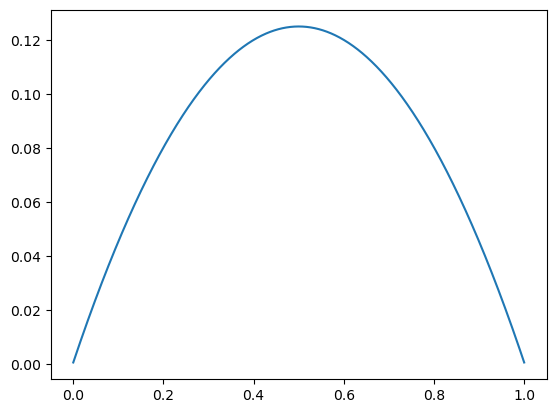

In [27]:
plt.plot(np.linspace(0,1,tpetra_map.getGlobalNumElements()), 
         tpetra_x.getLocalViewHost());

For a MPI distributed version of this code, check out the test in `packages/PyTrilinos2/test/Stratimikos.py`.